In [46]:
import pydiffvg
import os
import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
from einops import rearrange
from pathlib import Path
from subprocess import call

import matplotlib.pyplot as plt

pydiffvg.set_print_timing(True)

In [ ]:
# adapted from https://github.com/BachiLi/diffvg/blob/master/apps/painterly_rendering.py

In [2]:
torch.cuda.is_available()

True

In [36]:
random.seed(1234)
torch.manual_seed(1234)
gamma = 1.

In [3]:
pydiffvg.set_use_gpu(torch.cuda.is_available())

In [4]:
perception_loss = ttools.modules.LPIPS().to(pydiffvg.get_device())

LPIPS is untested
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/estorrs/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [45]:
target_fp = '../data/tests/flower/flower.jpeg'
output_dir = '../data/tests/flower/test_v1'
Path(output_dir).mkdir(parents=True, exist_ok=True)

num_paths = 512
max_width = 4.
use_blob = False
num_iter = 250
loss_type = 'l2' # l2 or perception

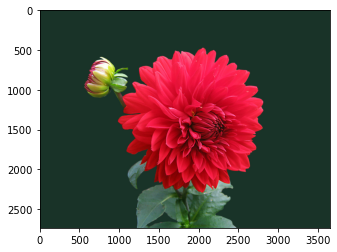

In [37]:
im = skimage.io.imread(target_fp)
plt.imshow(im)

In [38]:
canvas_width, canvas_height = im.shape[1], im.shape[0]

In [13]:
target = torch.from_numpy(img).to(torch.float32) / 255.0
target = target.to(pydiffvg.get_device())
target = target.unsqueeze(0)
target = rearrange(target, 'n h w c -> n c h w')
target.shape

torch.Size([1, 3, 2736, 3648])

In [22]:
torch.zeros(10, dtype = torch.int32) + 2

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=torch.int32)

In [25]:
def create_vector_groups(num_paths, n_segments=(1, 3), use_blob=False, radius=.05):
    shapes, shape_groups = [], []
    for i in range(num_paths):
        num_segments = random.randint(n_segments[0], n_segments[1])
        num_control_points = torch.full((num_segments,), 2, dtype = torch.int32)
        points = [(random.random(), random.random())]
        p0 = points[0]
        for j in range(num_segments):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            
            if use_blob:
                if j < num_segments - 1:
                    points.append(p3)
                    p0 = p3
            else:
                points.append(p3)
                p0 = p3
            
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 1] *= canvas_height

        path = pydiffvg.Path(
            num_control_points=num_control_points,
            points=points,
            stroke_width=torch.tensor(1.0),
            is_closed=use_blob)
        shapes.append(path)

        if use_blob:
            path_group = pydiffvg.ShapeGroup(
                shape_ids=torch.tensor([len(shapes) - 1]),
                fill_color = torch.tensor(
                    [random.random(),
                     random.random(),
                     random.random(),
                     random.random()]))
        else:
            path_group = pydiffvg.ShapeGroup(
                shape_ids=torch.tensor([len(shapes) - 1]),
                fill_color = None,
                stroke_color = torch.tensor(
                    [random.random(),
                     random.random(),
                     random.random(),
                     random.random()]))
        shape_groups.append(path_group)
    return shapes, shape_groups  

In [26]:
shapes, shape_groups = create_vector_groups(num_paths, n_segments=(1, 3), use_blob=False)
# shapes, shape_groups = create_vector_groups(num_paths, n_segments=(3, 5), use_blob=True)

In [41]:
def setup_scene(canvas_width, canvas_height, shapes, shape_groups,
                num_samples_x=2, num_samples_y=2, seed=0):
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)

    render = pydiffvg.RenderFunction.apply
    img = render(
        canvas_width,
        canvas_height,
        num_samples_x,
        num_samples_y,
        seed,
        None,
        *scene_args)
    
    return scene_args, render, img

In [39]:
scene_args, render, img = setup_scene(canvas_width, canvas_height, shapes, shape_groups)
pydiffvg.imwrite(img.cpu(), os.path.join(output_dir, 'init.png'), gamma=gamma)

Scene construction, time: 6.65579 s
Forward pass, time: 0.20813 s


In [42]:
points_vars = []
stroke_width_vars = []
color_vars = []
for path in shapes:
    path.points.requires_grad = True
    points_vars.append(path.points)
    
    if not use_blob:
        path.stroke_width.requires_grad = True
        stroke_width_vars.append(path.stroke_width)

for group in shape_groups:
    if use_blob:
        group.fill_color.requires_grad = True
        color_vars.append(group.fill_color)
    else:
        group.stroke_color.requires_grad = True
        color_vars.append(group.stroke_color)

In [43]:
# Optimize
points_optim = torch.optim.Adam(points_vars, lr=1.0)
if len(stroke_width_vars) > 0:
    width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

In [47]:
def compose_with_background(img):
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    return img
    
def run_iterations(num_iter, target, canvas_height, canvas_width, shapes, shape_groups,
                  loss_type='l2', max_width=4., use_blob=False, save_interval=10, gamma=1.,
                  save_video=True):
    for t in range(num_iter):
        # zero grads
        points_optim.zero_grad()
        if len(stroke_width_vars) > 0:
            width_optim.zero_grad()
        color_optim.zero_grad()
        
        # forward
        scene_args, render, img = setup_scene(canvas_width, canvas_height, shapes, shape_groups)
        
        # white background
        img = compose_with_background(img)
        
        # save intermediate render.
        pydiffvg.imwrite(img.cpu(), os.path.join(output_dir, f'iter_{t}.png'), gamma=gamma)
        
        img = img[:, :, :3]
        # convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = rearrange(img, 'n h w c -> n c h w')
        
        if loss_type == 'l2':
            loss = (img - target).pow(2).mean()
        elif loss_type == 'perception':
            loss = perception_loss(img, target) + (img.mean() - target.mean()).pow(2)
            
        loss.backward()

        print(f'iteration {t} | render loss: {loss.item()}')
        
        # Take a gradient descent step.
        points_optim.step()
        if len(stroke_width_vars) > 0:
            width_optim.step()
        color_optim.step()
        
        # clamp vars
        for path in shapes:
            if stroke_width_vars:
                path.stroke_width.data.clamp_(1.0, max_width)
        for group in shape_groups:
            if use_blob:
                group.fill_color.data.clamp_(0.0, 1.0)
            else:
                group.stroke_color.data.clamp_(0.0, 1.0)

        if t % save_interval == 0 or t == num_iter - 1:
            pydiffvg.save_svg(os.path.join(output_dir, f'iter_{t}.svg'),
                              canvas_width, canvas_height, shapes, shape_groups)
                              
    # render the final result.
    scene_args, render, img = setup_scene(canvas_width, canvas_height, shapes, shape_groups)
    pydiffvg.imwrite(img.cpu(), os.path.join(output_dir, f'final.png'), gamma=gamma)
    pydiffvg.save_svg(os.path.join(output_dir, f'final.svg'),
                      canvas_width, canvas_height, shapes, shape_groups)
    
    if save_video:
        # convert the intermediate renderings to a video.
        call(["ffmpeg", "-framerate", "24", "-i",
            os.path.join(output_dir, 'iter_%d.png'), "-vb", "20M",
            os.path.join(output_dir, 'final.mp4')])
        

In [48]:
run_iterations(num_iter, target, canvas_height, canvas_width, shapes, shape_groups,
               loss_type=loss_type, max_width=max_width, use_blob=use_blob)

Scene construction, time: 0.01994 s
Forward pass, time: 0.18681 s
Backward pass, time: 1.54711 s
iteration 0 | render loss: 0.642751932144165
Scene construction, time: 0.00190 s
Forward pass, time: 0.14218 s
Backward pass, time: 1.50750 s
iteration 1 | render loss: 0.6417380571365356
Scene construction, time: 0.00112 s
Forward pass, time: 0.14369 s
Backward pass, time: 1.51836 s
iteration 2 | render loss: 0.6406607627868652
Scene construction, time: 0.00108 s
Forward pass, time: 0.14500 s
Backward pass, time: 1.45771 s
iteration 3 | render loss: 0.6395230889320374
Scene construction, time: 0.00101 s
Forward pass, time: 0.14603 s
Backward pass, time: 1.49429 s
iteration 4 | render loss: 0.6383259892463684
Scene construction, time: 0.00131 s
Forward pass, time: 0.14849 s
Backward pass, time: 1.53260 s
iteration 5 | render loss: 0.6370600461959839
Scene construction, time: 0.00248 s
Forward pass, time: 0.14966 s
Backward pass, time: 1.54609 s
iteration 6 | render loss: 0.6357223987579346


Forward pass, time: 0.31268 s
Backward pass, time: 1.75998 s
iteration 57 | render loss: 0.5367586612701416
Scene construction, time: 0.00133 s
Forward pass, time: 0.31762 s
Backward pass, time: 1.82404 s
iteration 58 | render loss: 0.5355180501937866
Scene construction, time: 0.00129 s
Forward pass, time: 0.32301 s
Backward pass, time: 1.83055 s
iteration 59 | render loss: 0.5343047380447388
Scene construction, time: 0.00133 s
Forward pass, time: 0.32657 s
Backward pass, time: 1.84594 s
iteration 60 | render loss: 0.5331124067306519
Scene construction, time: 0.00102 s
Forward pass, time: 0.32976 s
Backward pass, time: 1.79405 s
iteration 61 | render loss: 0.5319145321846008
Scene construction, time: 0.00127 s
Forward pass, time: 0.33542 s
Backward pass, time: 1.86802 s
iteration 62 | render loss: 0.5307590365409851
Scene construction, time: 0.00098 s
Forward pass, time: 0.34032 s
Backward pass, time: 1.85719 s
iteration 63 | render loss: 0.529621958732605
Scene construction, time: 0.0

Forward pass, time: 0.56536 s
Backward pass, time: 2.27094 s
iteration 114 | render loss: 0.4836181104183197
Scene construction, time: 0.00136 s
Forward pass, time: 0.56921 s
Backward pass, time: 2.34859 s
iteration 115 | render loss: 0.4828694760799408
Scene construction, time: 0.00145 s
Forward pass, time: 0.57558 s
Backward pass, time: 2.32883 s
iteration 116 | render loss: 0.48209914565086365
Scene construction, time: 0.00097 s
Forward pass, time: 0.58093 s
Backward pass, time: 2.33600 s
iteration 117 | render loss: 0.4813423752784729
Scene construction, time: 0.00105 s
Forward pass, time: 0.58596 s
Backward pass, time: 2.32154 s
iteration 118 | render loss: 0.4805843234062195
Scene construction, time: 0.00133 s
Forward pass, time: 0.58943 s
Backward pass, time: 2.37297 s
iteration 119 | render loss: 0.479835569858551
Scene construction, time: 0.00099 s
Forward pass, time: 0.59365 s
Backward pass, time: 2.39163 s
iteration 120 | render loss: 0.4791117012500763
Scene construction, t

Scene construction, time: 0.00107 s
Forward pass, time: 0.81790 s
Backward pass, time: 3.00887 s
iteration 171 | render loss: 0.44426441192626953
Scene construction, time: 0.00129 s
Forward pass, time: 0.82256 s
Backward pass, time: 3.00122 s
iteration 172 | render loss: 0.44364693760871887
Scene construction, time: 0.00141 s
Forward pass, time: 0.82694 s
Backward pass, time: 2.98180 s
iteration 173 | render loss: 0.4430200457572937
Scene construction, time: 0.00142 s
Forward pass, time: 0.83077 s
Backward pass, time: 3.05044 s
iteration 174 | render loss: 0.442414253950119
Scene construction, time: 0.00132 s
Forward pass, time: 0.83000 s
Backward pass, time: 3.05770 s
iteration 175 | render loss: 0.4418032765388489
Scene construction, time: 0.00119 s
Forward pass, time: 0.83382 s
Backward pass, time: 2.99442 s
iteration 176 | render loss: 0.4412018358707428
Scene construction, time: 0.00088 s
Forward pass, time: 0.84000 s
Backward pass, time: 2.97800 s
iteration 177 | render loss: 0.4

Backward pass, time: 3.61636 s
iteration 227 | render loss: 0.413409948348999
Scene construction, time: 0.00108 s
Forward pass, time: 1.05359 s
Backward pass, time: 3.65836 s
iteration 228 | render loss: 0.412897527217865
Scene construction, time: 0.00130 s
Forward pass, time: 1.05887 s
Backward pass, time: 3.65746 s
iteration 229 | render loss: 0.4124041199684143
Scene construction, time: 0.00101 s
Forward pass, time: 1.06375 s
Backward pass, time: 3.68563 s
iteration 230 | render loss: 0.41189879179000854
Scene construction, time: 0.00098 s
Forward pass, time: 1.06389 s
Backward pass, time: 3.66118 s
iteration 231 | render loss: 0.4113768935203552
Scene construction, time: 0.00134 s
Forward pass, time: 1.07223 s
Backward pass, time: 3.67789 s
iteration 232 | render loss: 0.4108899235725403
Scene construction, time: 0.00129 s
Forward pass, time: 1.07492 s
Backward pass, time: 3.73288 s
iteration 233 | render loss: 0.4103878438472748
Scene construction, time: 0.00128 s
Forward pass, ti

ffmpeg version 5.0 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1646229198505/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1646229198505/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1646229198505/_build_env/bin/pkg-config
  libavutil      57. 17.10

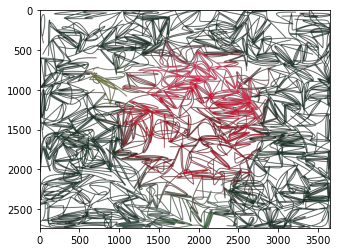

In [50]:
final_img = skimage.io.imread(os.path.join(final.png')
plt.imshow(final_img)